<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE5] - Another game play : About the CelebA dataset
<!-- DESC --> Episode 1 : Presentation of the CelebA dataset and problems related to its size
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Data **analysis**
 - Problems related to the use of **more real datasets**

We'll do the same thing again but with a more interesting dataset:  **CelebFaces**  
"[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations."

## Step 1 - Import and init

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, transform

import os,time,sys,json,glob
import csv
import math, random

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('VAE5')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.14
Notebook id          : VAE5
Run time             : Wednesday 10 February 2021, 11:02:39
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Understanding the dataset

### 2.1 - Read the catalog file

In [2]:
dataset_csv = f'{datasets_dir}/celeba/origine/list_attr_celeba.csv'
dataset_img = f'{datasets_dir}/celeba/origine/img_align_celeba'

# ---- Read dataset attributes

dataset_desc = pd.read_csv(dataset_csv, header=0)

# ---- Have a look

display(dataset_desc.head(10))

print(f'\nDonnées manquantes : {dataset_desc.isna().sum().sum()}')
print(f'dataset_desc.shape : {dataset_desc.shape}')

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
5,000006.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,1,-1,1,-1,-1,1
6,000007.jpg,1,-1,1,1,-1,-1,1,1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
7,000008.jpg,1,1,-1,1,-1,-1,1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
8,000009.jpg,-1,1,1,-1,-1,1,1,-1,-1,...,-1,1,-1,-1,1,-1,1,-1,-1,1
9,000010.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1



Données manquantes : 0
dataset_desc.shape : (202599, 41)


### 2.2 - Load 1000 images

In [3]:
pwk.chrono_start()

nb_images=1000
filenames = [ f'{dataset_img}/{i}' for i in dataset_desc.image_id[:nb_images] ]
x=[]
for filename in filenames:
    image=io.imread(filename)
    x.append(image)
    pwk.update_progress("1000 images :",len(x),nb_images)
x_data=np.array(x)
x=None
    
duration=pwk.chrono_stop()
print(f'\nDuration   : {duration:.2f} s')
print(f'Shape is   : {x_data.shape}')
print(f'Numpy type : {x_data.dtype}')

pwk.display_md('<br>**Note :** Estimation for **200.000** normalized images : ')
x_data=x_data/255
print(f'Charging time : {200*duration:.2f} s or {pwk.hdelay(200*duration)}')
print(f'Numpy type    : {x_data.dtype}')
print(f'Memory size   : {pwk.hsize(200*x_data.nbytes)}')

1000 images :    [########################################] 100.0% of 1000

Duration   : 11.28 s
Shape is   : (1000, 218, 178, 3)
Numpy type : uint8


<br>**Note :** Estimation for **200.000** normalized images : 

Charging time : 2255.79 s or 0:37:35
Numpy type    : float64
Memory size   : 173.5 Go


## Step 3 - Have a look

### 3.1 - Few statistics
We want to know if our images are homogeneous in terms of size, ratio, width or height.

In [4]:
data_size  = []
data_ratio = []
data_lx    = []
data_ly    = []

for image in x_data:
    (lx,ly,lz) = image.shape
    data_size.append(lx*ly/1024)
    data_ratio.append(lx/ly)
    data_lx.append(lx)
    data_ly.append(ly)

df=pd.DataFrame({'Size':data_size, 'Ratio':data_ratio, 'Lx':data_lx, 'Ly':data_ly})
display(df.describe().style.format("{0:.2f}").set_caption("About our images :"))
    

,Size,Ratio,Lx,Ly
count,1000.00,1000.00,1000.00,1000.00
mean,37.89,1.22,218.00,178.00
std,0.00,0.00,0.00,0.00
min,37.89,1.22,218.00,178.00
25%,37.89,1.22,218.00,178.00
50%,37.89,1.22,218.00,178.00
75%,37.89,1.22,218.00,178.00
max,37.89,1.22,218.00,178.00


### 3.2 - What does it really look like

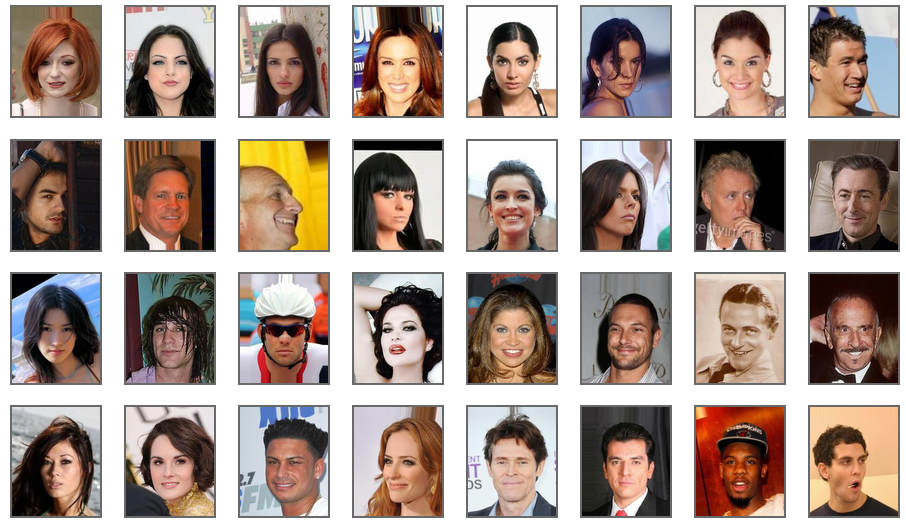

In [5]:
samples = [ random.randint(0,len(x_data)-1) for i in range(32)]
pwk.plot_images(x_data, indices=samples, columns=8, x_size=2, y_size=2, save_as='01-celebA')

<div class=warn>
    Fine ! :-)<br>But how can we effectively use this dataset, considering its size and the number of files ?<br>
    We're talking about a 10' to 20' of loading time and 170 GB of data... ;-(<br><br>
    The only solution will be to:
    <ul>
        <li>group images into clusters, to limit the number of files,
        <li>read the data gradually, because not all of it can be stored in memory
    </ul>
    Welcome in the real world ;-)
<div/>

In [6]:
pwk.end()

End time is : Wednesday 10 February 2021, 11:03:05
Duration is : 00:00:25 477ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>